## Problem description

Success in any financial market requires one to identify solid investments. When a stock or derivative is undervalued, it makes sense to buy. If it's overvalued, perhaps it's time to sell. While these finance decisions were historically made manually by professionals, technology has ushered in new opportunities for retail investors. Data scientists, specifically, may be interested to explore quantitative trading, where decisions are executed programmatically based on predictions from trained models.

The competition will involve building portfolios from the stocks eligible for predictions (around 2,000 stocks). Specifically, each participant ranks the stocks from highest to lowest expected returns and is evaluated on the difference in returns between the top and bottom 200 stocks. You'll have access to financial data from the Japanese market, such as stock information and historical stock prices to train and test your model.

Detail about the evaluation metric is geiven https://www.kaggle.com/code/smeitoma/jpx-competition-metric-definition

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jpx-tokyo-stock-exchange-prediction/stock_list.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/options.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/financials.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/secondary_stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/trades.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/__init__.py
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_fin_spec.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv
/kaggle/input/jpx-tokyo-stock-

In [2]:
import os
from decimal import ROUND_HALF_UP, Decimal

from lightgbm import LGBMRegressor
from tqdm import tqdm

import matplotlib.pyplot as plt
import time as time

In [3]:
import xgboost as xgb

### Adjust close price and sharpe ratio metric

In [4]:
def adjust_price(price):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)

    price.set_index("Date", inplace=True)
    return price

def set_rank(df, column='predict'):
    """
    Args:
        df (pd.DataFrame): including predict column
    Returns:
        df (pd.DataFrame): df with Rank
    """
    # sort records to set Rank
    df = df.sort_values(column, ascending=False)
    # set Rank starting from 0
    df.loc[:, "Rank"] = np.arange(len(df[column]))
    return df

def calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio, column):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')[column][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)[column][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, 
                              toprank_weight_ratio: float = 2, column: str = 'Target') -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """    

    buf = df.groupby('Date').apply(calc_spread_return_per_day, portfolio_size, toprank_weight_ratio, column)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio


In [5]:
# set base_dir to load data
base_dir = "../input/jpx-tokyo-stock-exchange-prediction"
# There are three types of stock_price.csv
# We use one in the train_files folder for this notebook.
train_files_dir = f"{base_dir}/train_files"

# for forecasting phase leaderboard, you may want to include stock_price.csv in the supplemental_files folder.
# You can remove "forecasting phase leaderboard" comments in this notebook to use stock_price.csv in the supplemental_files folder.
# forecasting phase leaderboard:
# supplemental_files_dir = f"{base_dir}/supplemental_files"

In [6]:
# load stock price data
df_stock_price = pd.read_csv(f"{train_files_dir}/stock_prices.csv")
df_stock_list=pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/stock_list.csv")
df_suppl_stocks = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv', 
                              parse_dates=["Date"])


# 1. Data exploration

In [7]:
#Looking for missing values
print('---------for training data---------')
for column in df_stock_price.columns:
    print(column, ': ', df_stock_price[column].isna().sum())
    
print('------ for supplementary data ---------')    
for column in df_suppl_stocks.columns:
    print(column, ': ', df_suppl_stocks[column].isna().sum())
    
print('df_stock_price range date [', df_stock_price['Date'].min(),',', df_stock_price['Date'].max(),']')
print('df_suppl_stocks range date [', df_suppl_stocks['Date'].min(),',',df_suppl_stocks['Date'].max(),']')    

---------for training data---------
RowId :  0
Date :  0
SecuritiesCode :  0
Open :  7608
High :  7608
Low :  7608
Close :  7608
Volume :  0
AdjustmentFactor :  0
ExpectedDividend :  2313666
SupervisionFlag :  0
Target :  238
------ for supplementary data ---------
RowId :  0
Date :  0
SecuritiesCode :  0
Open :  818
High :  818
Low :  818
Close :  818
Volume :  0
AdjustmentFactor :  0
ExpectedDividend :  267870
SupervisionFlag :  0
Target :  8
df_stock_price range date [ 2017-01-04 , 2021-12-03 ]
df_suppl_stocks range date [ 2021-12-06 00:00:00 , 2022-06-24 00:00:00 ]


In [8]:
print(df_stock_price.shape, df_suppl_stocks.shape, df_stock_price.shape[0] + df_suppl_stocks.shape[0])
df_stock_price = pd.concat([df_stock_price, df_suppl_stocks])
print(df_stock_price.shape)

(2332531, 12) (269881, 12) 2602412
(2602412, 12)


In [9]:
df_stock_price = adjust_price(df_stock_price) #adjust_price deals with nan
df_stock_price.reset_index(inplace=True)
df_stock_price.shape

(2602412, 14)

In [10]:
# df_stock_price=df_stock_price.drop('ExpectedDividend',axis=1).fillna(0)
## Droping not used fields
df_stock_price.drop(['RowId', 'ExpectedDividend', 'SupervisionFlag','AdjustmentFactor','CumulativeAdjustmentFactor','Close'], axis=1, inplace=True)
df_stock_price.shape

(2602412, 8)

In [11]:
# dropping rows where target is nan. Then, fill the remainded nan's with zero 
df_stock_price.dropna(subset=['Target'], inplace=True)
df_stock_price = df_stock_price.fillna(0)    
print(df_stock_price.shape)
#Looking for missing values
for column in df_stock_price.columns:
    print(column, ': ', df_stock_price[column].isna().sum())

(2602166, 8)
Date :  0
SecuritiesCode :  0
Open :  0
High :  0
Low :  0
Volume :  0
Target :  0
AdjustedClose :  0


### **Exploring the stock_list data**

See in: why we use the '33SectorCode' as inidiator to classify the series

In [12]:
## clean the space of 17SectorName 
df_stock_list['17SectorName'] = df_stock_list['17SectorName'].str.strip()

In [13]:
## ## grouped by 17SectorName we have 18 groups 
df_stock_list[['SecuritiesCode', '17SectorName']].groupby(['17SectorName']).count().sort_values('SecuritiesCode', ascending=False)

,SecuritiesCode
17SectorName,
"IT & SERVICES, OTHERS",1188
-,500
RETAIL TRADE,359
COMMERCIAL & WHOLESALE TRADE,320
CONSTRUCTION & MATERIALS,316
ELECTRIC APPLIANCES & PRECISION INSTRUMENTS,305
RAW MATERIALS & CHEMICALS,294
MACHINERY,230
REAL ESTATE,143


In [14]:
## grouped by '33SectorCode', and '17SectorName' we have 34 groups 
(df_stock_list[['SecuritiesCode', '17SectorName', '33SectorCode']].groupby(['33SectorCode', '17SectorName']).count().sort_values('SecuritiesCode', ascending=False)).reset_index().sort_values('17SectorName')

,33SectorCode,17SectorName,SecuritiesCode
2,-,-,500
27,3350,AUTOMOBILES & TRANSPORTATION EQUIPMENT,19
12,3700,AUTOMOBILES & TRANSPORTATION EQUIPMENT,95
13,7050,BANKS,93
4,6050,COMMERCIAL & WHOLESALE TRADE,320
14,3550,CONSTRUCTION & MATERIALS,90
17,3400,CONSTRUCTION & MATERIALS,56
8,2050,CONSTRUCTION & MATERIALS,170
5,3650,ELECTRIC APPLIANCES & PRECISION INSTRUMENTS,255
19,3750,ELECTRIC APPLIANCES & PRECISION INSTRUMENTS,50


In [15]:
## Merge stocks with sectors data
df_stock_price = pd.merge(df_stock_price, df_stock_list[['33SectorCode', '17SectorName', 'SecuritiesCode']], on='SecuritiesCode', how='inner')
df_stock_price['33SectorCode'] = df_stock_price['33SectorCode'].astype(int)
print(df_stock_price.shape)

(2602166, 10)


In [16]:
list_33SectorCode = df_stock_price[['SecuritiesCode','33SectorCode']].groupby('33SectorCode').count().reset_index().sort_values('SecuritiesCode', 
                                                                                                                                    ascending=False)['33SectorCode'].values    

# 2. Models

Our goal in this comptetion is to maximize the sharpe ratio metric, which is based on 200-top and 200-bottom ranked stocks. The rankig is directly computed from the future rate of change that is defined as follow:

$$r_{(k,t)}=\frac{C_{(k,t+2)}−C_{(k,t+1)}}{C_{(k,t+1)}}$$

Where $r_{(k,t)}$ is the rate of change for the stock $k$ in the time $t$, and $C_{(k,t+1)}$ and $C_{(k,t+2)}$ is the adjusted close price for the $t+1$ or next day, and $t+2$ or nex next day respectively.

So, We explore three models:
1. model to predict the future rate of change $r_{(k,t)}$
2. model to predict the close prices $C_{(k,t+1)}$ and $C_{(k,t+2)}$, and then compute $r_{(k,t)}$
3. compute the predicted $r_{(k,t)}$ based on the mean the both model described above.

In [17]:
def generate_next_targets(df, column):
    def compute_lags(df, column):
        df['CloseNext'] = df[column].shift(-1)
        df['CloseNextNext'] = df[column].shift(-2)
        return df
    df = df.groupby('SecuritiesCode').apply(lambda x:compute_lags(x, column))
    return df

In [18]:
## Genrating CloseNext and CLoseNextNext columns
df_stock_price_next = generate_next_targets(df_stock_price, 'AdjustedClose')
df_stock_price_next.dropna(subset=['CloseNext', 'CloseNextNext'], inplace=True)
print('difference in size between df_stock_price and df_stock_price_next :', df_stock_price.shape, df_stock_price_next.shape)

difference in size between df_stock_price and df_stock_price_next : (2602166, 10) (2598166, 12)


## 2.1 Features

In [19]:
def percentage_change_feature(df, column, config_feature):
    for period in config_feature['periods']:        
        df["PC_"+str(period)] = df[column].pct_change(period) 
    return df

def volatility_feature(df, column, config_feature):
    for period in config_feature['periods']:        
        df["VOLAT_"+str(period)] = (np.log(df[column]).diff().rolling(period).std())
    return df

def moving_average_feature(df, column, config_feature):
    for period in config_feature['periods']:        
        df["MA_"+str(period)] = df[column].rolling(window=period).mean().values
    return df

def exponential_moving_average_feature(df, column, config_feature):
    for period in config_feature['periods']:        
        df["EMA_"+str(period)] = df[column].ewm(span=period,adjust=False).mean().values
    return df

def divergence(df, column, config_feature):
    for period in config_feature['periods']:        
        std = df[column].rolling(period, min_periods=1).std()
        mean = df[column].rolling(period, min_periods=1).mean()
        df["DIV_"+str(period)] = (df[column]-mean) / std  
    return df

def rsi(df, column, config_feature):
    # rate stregth index rsi=gain/(gain+loss)
    for period in config_feature['periods']:   
        df["RSI_"+str(period)] = (df[column] - df[column].shift(1)).rolling(period).apply(lambda s:s[s>0].sum()/abs(s).sum())
    return df

def stochastic(df, column, config_feature):
    
    _min = df[column].rolling(config_feature['k']).min()
    _max = df[column].rolling(config_feature['k']).max()
    _k = (df[column] - _min)/(_max - _min)
    _d1 = _k.rolling(config_feature['n']).mean()
    _d2 = _d1.rolling(config_feature['m']).mean()
    df["%K_"+str(config_feature['k'])] = _k
    df["%FAST-%D"+str(config_feature['n'])] = _d1
    df["%SLOW-%D"+str(config_feature['m'])] = _d2
    return df

def psy(df, column, config_feature):
    for period in config_feature['periods']:
        df["PSY_"+str(period)] = (df[column] - df[column].shift(1)).rolling(period).apply(lambda s:(s>=0).mean())
    return df

def ich(df, column, config_feature):
    df["CONV_"+str(config_feature['conv'])] = df[column].rolling(config_feature['conv']).apply(lambda s:(s.max()+s.min())/2) #5
    df["BASE_"+str(config_feature['base'])] = df[column].rolling(config_feature['base']).apply(lambda s:(s.max()+s.min())/2) #15
    df["PRE_1"] = ((df["CONV_"+str(config_feature['conv'])] + df["BASE_"+str(config_feature['base'])])/2).shift(config_feature['pre_1'])
    df["PRE_2"] = df[column].rolling(2*config_feature['base']).apply(lambda s:(s.max()+s.min())/2).shift(config_feature['pre_2'])
    #df["LAG_20"] = df[column].shift(20)
    return df

def compute_local_features(price, column="AdjustedClose", config_feature={}):

    if 'pc' in config_feature:
        price = percentage_change_feature(price, column, config_feature['pc'])
    if 'volat' in config_feature:
        price = volatility_feature(price, column, config_feature['volat'])
    if 'ma' in config_feature:
        price = moving_average_feature(price, column, config_feature['ma'])
    if 'ema' in config_feature:
        price = exponential_moving_average_feature(price, column, config_feature['ema'])
    if 'div' in config_feature:
        price = divergence(price, column, config_feature['div']) 
    if 'rsi' in config_feature:
        price = rsi(price, column, config_feature['rsi']) 
    if 'stochastic' in config_feature:
        price = stochastic(price, column, config_feature['stochastic'])
    if 'psy' in config_feature:
        price = psy(price, column, config_feature['psy'])
    if 'ich' in config_feature:
        price = ich(price, column, config_feature['ich'])
    
    
    # filling data for nan and inf
    price = price.fillna(0)
    price = price.replace([np.inf, -np.inf], 0)
    
    return price

def get_features(config_feature, df_stock_price):
    
    # generate features
    df_stock_price.set_index('SecuritiesCode', inplace=True)
    buff = []
    columns = config_feature['columns']
    over_column = config_feature['over_column']
    
    for code in df_stock_price.index.unique():
        feat = compute_local_features(df_stock_price.loc[code][columns].copy(), over_column, config_feature)
        buff.append(feat)
    df_features = pd.concat(buff)
    df_stock_price.reset_index(inplace=True)
    return df_features

## 2.2 Hyperparameters search 

In this section we execute the method based on Bayesian optimization to search the hyperparaneters. Several approches would be used to effectively select the best set of parameters, here we run for several iteration and simple select as the best model the one that produce minimum loss. 

In [20]:
import IPython

# machine learning model
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

from sklearn.model_selection import TimeSeriesSplit

#hyper parameter search
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args
import gc

In [21]:
def function_split(x, idx_train, idx_val):
    list_x_train = []
    list_x_val = []
    x = x.reset_index()
    x.set_index('SecuritiesCode', inplace=True)
    for sec in x.index.unique():                
        x_tmp = x.loc[sec].sort_values('Date')        
        list_x_train.append(x_tmp.iloc[idx_train])
        list_x_val.append(x_tmp.iloc[idx_val])                
    return (pd.concat(list_x_train), pd.concat(list_x_val))

class Manage_split_features:
    def __init__(self, x_train, config_feature, num_folds, num_iterations):
        self.x_train = x_train
        self.config_feature = config_feature        
        self.num_folds = num_folds
        self.num_iterations = num_iterations
        self.dic_features_fold = {}
    def init_dict(self):
        for fold in self.num_folds:
            self.dic_features_fold[fold] = None
    def get_features(self, iteration, fold, index_train, index_val):
        if iteration == 0:            
            x_train_fold, x_val_fold = function_split(self.x_train, index_train, index_val)
            x_train_fold.reset_index(inplace=True)
            x_val_fold.reset_index(inplace=True)               
            print("\ncomputing features fold: ", fold)
            x_train_fold = get_features(self.config_feature, x_train_fold)            
            x_val_fold = get_features(self.config_feature, x_val_fold)
            self.dic_features_fold[fold] = {'train_fold':x_train_fold, 'val_fold':x_val_fold}
                    
        return self.dic_features_fold[fold]['train_fold'], self.dic_features_fold[fold]['val_fold']

In [22]:
#Define the space of search for each hyperparameter
# dim_learning_rate = Real(low=1e-4, high=0.1, prior='log-uniform', name='learning_rate')
dim_learning_rate = Categorical(categories=[0.01, 0.05, 0.1], name='learning_rate')
dim_max_depth = Categorical(categories=[5, 9, 10, 14], name='max_depth') #Real(low=0.1, high=0.9, name='rho_value')
dim_min_child_weight = Categorical(categories=[1, 5, 6, 10], name='min_child_weight')

dim_subsample = Real(low=0.1, high=1.0, name='subsample') 
dim_colsample_bytree = Real(low=0.1, high=1.0, name='colsample_bytree') 
dim_reg_alpha = Real(low=0.1, high=0.8, name='reg_alpha')
dim_n_estimators = Categorical(categories=[30, 50, 70, 100], name='n_estimators')
# dim_n_estimators = Categorical(categories=[150], name='n_estimators')

dimensions = [dim_learning_rate, dim_max_depth, dim_min_child_weight, dim_subsample, dim_colsample_bytree,
             dim_reg_alpha, dim_n_estimators]

def train_model(param_tmp, x_train, y_train, x_val, y_val, early_stoping=False, 
                early_stopping_rounds=50, verbose=True):    
    model = XGBRegressor(learning_rate = param_tmp['learning_rate'], 
                         max_depth = param_tmp['max_depth'],
                         min_child_weight = param_tmp['min_child_weight'],
                         subsample = param_tmp['subsample'],
                         colsample_bytree = param_tmp['colsample_bytree'],
                         reg_alpha = param_tmp['reg_alpha'],
                         n_estimators = param_tmp['n_estimators']) 
    
    if early_stoping:                
        eval_set = [(x_val, y_val)]
        model.fit(x_train, y_train, early_stopping_rounds=early_stopping_rounds,  
                  eval_set=eval_set, verbose=verbose)
    else:
        
        model.fit(x_train, y_train)

    y_pred_train = model.predict(x_train)  
    y_pred_val = model.predict(x_val)               

    df_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train, multioutput='raw_values'))
    df_rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val, multioutput='raw_values'))   
    
    return model, df_rmse_train, df_rmse_val

iteration = 0
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, max_depth, min_child_weight, subsample, colsample_bytree, reg_alpha, n_estimators):   
    global iteration   
    global list_metrics_results
    global manage_split
    
    def fitness_function(param_tmp):                              
        num_partition = 0         
        list_rmse_val = []        
        tscv = TimeSeriesSplit(n_splits=3, max_train_size=None, test_size=30, gap=5)    
        
        #for index_train, index_val in tscv.split(np.arange(x_train.shape[0])): 
        #for index_train, index_val in tscv.split(np.arange(x_train_raw.shape[0]/x_train_raw['SecuritiesCode'].unique().shape[0])): 
        num_samples = x_train_raw[['Date', 'SecuritiesCode']].groupby('SecuritiesCode').count().min().values[0]
        for index_train, index_val in tscv.split(np.arange(num_samples)): 
            
            print('------------------')               
            print('__ partition:', num_partition,'__')
            print('index_train:', index_train[0], 'to', index_train[-1])
            print('index_val:',  index_val[0], 'to', index_val[-1])            
            print('split train, val :', index_train.shape, index_val.shape)
            print('------------------')   
            
            '''
            x_train_fold, x_val_fold = function_split(x_train, index_train, index_val)
            x_train_fold.reset_index(inplace=True)
            x_val_fold.reset_index(inplace=True)   
            print("\ncomputing features")
            x_train_fold = get_features(config_feature, x_train_fold)            
            x_val_fold = get_features(config_feature, x_val_fold)
            '''
            x_train_fold, x_val_fold = manage_split.get_features(iteration, num_partition, index_train, index_val)
            print('shape x_train_fold, x_val_fold ', x_train_fold.shape, x_val_fold.shape)                                 
                        
            model, df_rmse_train, df_rmse_val = train_model(param_tmp, 
                                                            x_train_fold[FEATURES].values, x_train_fold[TARGET].values, 
                                                            x_val_fold[FEATURES].values, x_val_fold[TARGET].values,
                                                            early_stoping=False, early_stopping_rounds=5, verbose=True)                      
            
            print('rmse train:', df_rmse_train.mean(),'\n', 
                  'rmse val:', df_rmse_val.mean(), '\n')
                                           
            list_rmse_val.append(np.round_(df_rmse_val.mean(),2))                                 
            num_partition += 1 
            
        IPython.display.clear_output()
        
        weights = np.array([1.0, 1.0, 1.0])         #np.array([0.6, 0.3, 0.1])
        mean_rmse = np.round(np.mean(list_rmse_val), 4)
        weight_mean_rmse = np.round(np.mean(np.array(list_rmse_val)*weights), 4)
        
        print("*** ---- Hyperparameters ---- ***")
        print(param_tmp)
        print('metrics:')
        print('mean_rmse:', mean_rmse, 'weight_mean_rmse:', weight_mean_rmse)                                   
        list_metrics_results.append({'mean_rmse':np.round(np.mean(list_rmse_val), 2), 
                                     'weight_mean_rmse':weight_mean_rmse,
                                     'cv_rmse_val':list_rmse_val})
                                     #'best_iteration':model.best_iteration}) 
        return weight_mean_rmse #mean_rmse

    print("____________Iteration:", iteration, "___________")
    
    param_tmp = {'learning_rate':learning_rate, 
              'max_depth': max_depth,  
              'min_child_weight':min_child_weight, 
              'subsample': subsample, 
              'colsample_bytree': colsample_bytree, 
              'reg_alpha': reg_alpha,
              'n_estimators': n_estimators} 
        
    accuracy = fitness_function(param_tmp)    

    iteration += 1 
    gc.collect()

    return accuracy

### **Config partition data and features**

In [23]:
## config list to save the results
list_metrics_from_hp_search = {'Target':[], 'CloseNext':[], 'CloseNextNext':[]}
list_hp_from_hp_search = {'Target':[], 'CloseNext':[], 'CloseNextNext':[]}
list_models_from_hp_search = {'Target':[], 'CloseNext':[], 'CloseNextNext':[]}

## Config data partition 
#with 2020-12-23 to ahead 
# TRAIN_END = "2021-08-31"    
# TEST_START = "2021-09-06"

#with all data
# TRAIN_END = '2021-07-30' 
# TEST_START = '2021-09-01'

#with 2020-12-23 to ahead + supplementary data as test
TRAIN_START = '2020-12-23' #2017-01-04
TRAIN_END = '2021-11-19' 
TEST_START = '2021-12-06'

'''
df_stock_price range date [ 2017-01-04 , 2021-12-03 ]
df_suppl_stocks range date [ 2021-12-06 00:00:00 , 2022-06-24 00:00:00 ]
'''

## config features
config_feature = {'pc':{'periods':[5, 10, 15, 20, 30]}, 
                  'volat':{'periods':[5, 10, 15, 20, 30]},
                  'ma':{'periods':[5, 10, 15, 20, 30]},
                  'ema':{'periods':[5, 10, 15, 20, 30]},                  
#                   'div':{'periods':[5, 15, 30]},                  
#                   'rsi':{'periods':[5, 15, 30]},                  
#                   'stochastic':{'k':30, 'n':5, 'm':15},
#                   'psy':{'periods':[5, 15, 30]},
#                   'ich':{'conv':5, 'base':15, 'pre_1':20, 'pre_2':20},                      
                  'over_column':'AdjustedClose',                  
                  'columns':['Date', 'Open', 'High', 'Low', 'Volume', 'AdjustedClose']}

FEATURES = [
            'Open', 'High', 'Low', 'Volume', 'AdjustedClose',  #as features
            'PC_5', 'PC_15', 'PC_30', 'PC_10', 'PC_20',          
            'VOLAT_5', 'VOLAT_15', 'VOLAT_30', 'VOLAT_10', 'VOLAT_20',
            'MA_5', 'MA_15', 'MA_30','MA_10', 'MA_20',          
            'EMA_5', 'EMA_15', 'EMA_30','EMA_10', 'EMA_20'   
#             'DIV_5', 'DIV_15', 'DIV_30',   
#             'RSI_5', 'RSI_15', 'RSI_30',
#             '%K_30', '%FAST-%D5', '%SLOW-%D15',
#             'PSY_5', 'PSY_15', 'PSY_30',
#             'CONV_5', 'BASE_15', 'PRE_1', 'PRE_2'    
          ]

### **Model 1: Model Target**

In [24]:
TARGET = ['Target']
config_feature['columns'] = ['Date', 'Open', 'High', 'Low', 'Volume', 'AdjustedClose', TARGET[0]]

NUM_MODELS = 33

#if TARGET[0] == 'Target':
df_train_model_target_raw = df_stock_price.set_index('Date').loc[TRAIN_START:TRAIN_END, :]
df_test_model_target_raw= df_stock_price.set_index('Date').loc[TEST_START:, :]  
    
print('Target :', TARGET, ', NUM_MODELS:', NUM_MODELS, ', len features:',len(FEATURES))

print(df_train_model_target_raw.index)
print(df_test_model_target_raw.index)
## 33 models using the 33SectorCode code sectors
if NUM_MODELS == 33:
    list_codes_models = list_33SectorCode.copy()

    df_train_model_target_raw.reset_index(inplace=True)
    df_train_model_target_raw.set_index('33SectorCode', inplace=True)
    display(df_train_model_target_raw.head(3))

    df_test_model_target_raw.reset_index(inplace=True)
    df_test_model_target_raw.set_index('33SectorCode', inplace=True)
    display(df_test_model_target_raw.head(3))


Target : ['Target'] , NUM_MODELS: 33 , len features: 25
DatetimeIndex(['2020-12-23', '2020-12-24', '2020-12-25', '2020-12-28',
               '2020-12-29', '2020-12-30', '2021-01-04', '2021-01-05',
               '2021-01-06', '2021-01-07',
               ...
               '2021-11-08', '2021-11-09', '2021-11-10', '2021-11-11',
               '2021-11-12', '2021-11-15', '2021-11-16', '2021-11-17',
               '2021-11-18', '2021-11-19'],
              dtype='datetime64[ns]', name='Date', length=446000, freq=None)
DatetimeIndex(['2021-12-06', '2021-12-07', '2021-12-08', '2021-12-09',
               '2021-12-10', '2021-12-13', '2021-12-14', '2021-12-15',
               '2021-12-16', '2021-12-17',
               ...
               '2022-06-13', '2022-06-14', '2022-06-15', '2022-06-16',
               '2022-06-17', '2022-06-20', '2022-06-21', '2022-06-22',
               '2022-06-23', '2022-06-24'],
              dtype='datetime64[ns]', name='Date', length=269873, freq=None)


,Date,SecuritiesCode,Open,High,Low,Volume,Target,AdjustedClose,17SectorName
33SectorCode,,,,,,,,,
50,2020-12-23,1301,2913.0,2920.0,2906.0,6300,-0.000343,2913.0,FOODS
50,2020-12-24,1301,2913.0,2937.0,2909.0,13900,0.011660,2917.0,FOODS
50,2020-12-25,1301,2903.0,2930.0,2903.0,8300,0.003729,2916.0,FOODS


,Date,SecuritiesCode,Open,High,Low,Volume,Target,AdjustedClose,17SectorName
33SectorCode,,,,,,,,,
50,2021-12-06,1301,2982.0,2982.0,2965.0,8900,-0.003263,2971.0,FOODS
50,2021-12-07,1301,2998.0,3065.0,2990.0,19100,0.009820,3065.0,FOODS
50,2021-12-08,1301,3080.0,3080.0,3035.0,11600,0.006483,3055.0,FOODS


In [25]:
print(list_codes_models)
print(len(list_metrics_from_hp_search['Target']))
print(len(list_hp_from_hp_search['Target']))
print(len(list_models_from_hp_search['Target']))

[5250 9050 6100 3650 6050 3200 3600 2050 3050 8050 7050 3700 3800 3250
 5050 3550 3750 3400 7200 3450 4050 3500 3100 7100 5200 3350 7150 3150
 3300   50 5100 1050 5150]
0
0
0


In [26]:
num_folds = 3 #folds for cross validation
n_calls = 11 #iterations for hyperparameters search method
df_train_raw = df_train_model_target_raw.copy()
df_test_raw = df_test_model_target_raw.copy()

list_metrics_from_hp_search[TARGET[0]] = []
list_hp_from_hp_search[TARGET[0]] = []
list_models_from_hp_search[TARGET[0]] = []
start = time.time()    

#This could be take long time, we only train two models for ilustration
for code_sec in tqdm(list_codes_models[0:2]): 
            
    x_train_raw = df_train_raw.loc[code_sec].copy()
    x_test_raw = df_test_raw.loc[code_sec].copy()            
    
    print("\ntrain:", x_train_raw.shape, x_train_raw.columns, 
         "\ntest:", x_test_raw.shape, x_test_raw.columns)
        
    manage_split = Manage_split_features(x_train_raw, config_feature, num_folds, num_iterations=n_calls)
                
    iteration = 0
    list_metrics_results = []
    default_parameters = [0.1, 9, 6, 0.8, 0.8, 0.1, 50]
    search_result = gp_minimize(func=fitness,
                                dimensions=dimensions,
                                acq_func='EI', # Expected Improvement.
                                n_calls=n_calls,
                                x0=default_parameters)

    gp_results = pd.DataFrame(np.hstack([search_result.func_vals.reshape(-1,1), np.array(search_result.x_iters)])).sort_values(0)
    gp_results.columns = ['metric', 'learning_rate', 'max_depth', 'min_child_weight', 'subsample', 
                          'colsample_bytree', 'reg_alpha', 'n_estimators']
    gp_results['metric'] = gp_results['metric'].astype(np.float32)
    gp_results = pd.concat([gp_results, pd.DataFrame(list_metrics_results)], axis=1)
    gp_results = gp_results.sort_values('metric')
        
    best_hp = gp_results.iloc[0, 1:8].to_dict() 
    
    best_hp['max_depth'] = int(best_hp['max_depth'])
    best_hp['n_estimators'] = int(best_hp['n_estimators'])             
    print('top:',0, 'param:', best_hp)    
        
    print('\ncomputing features train and test')
    x_train = get_features(config_feature, x_train_raw)            
    x_test = get_features(config_feature, x_test_raw)
    model, df_rmse_train, df_rmse_test = train_model(best_hp, x_train[FEATURES].values, x_train[TARGET].values, 
                                                     x_test[FEATURES].values, x_test[TARGET].values)
             
    print('rmse train:', df_rmse_train.mean(),' rmse test:', df_rmse_test.mean(),'\n')
    
    list_metrics_from_hp_search[TARGET[0]].append({'rmse train':df_rmse_train.mean(), 'rmse test':df_rmse_test.mean()})
    list_hp_from_hp_search[TARGET[0]].append({'code_sec': code_sec, 'hp':best_hp})    
    list_models_from_hp_search[TARGET[0]].append({'code_sec': code_sec, 'model':model})    

print(time.time()-start)    

*** ---- Hyperparameters ---- ***
{'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.8964320021310063, 'colsample_bytree': 0.1916237663473814, 'reg_alpha': 0.6247711469740854, 'n_estimators': 50}
metrics:
mean_rmse: 0.3 weight_mean_rmse: 0.3
top: 0 param: {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}

computing features train and test


100%|██████████| 2/2 [03:10<00:00, 95.11s/it]

rmse train: 0.024322257791877216  rmse test: 0.029255210783543418 

190.21898984909058


,metric,learning_rate,max_depth,min_child_weight,subsample,colsample_bytree,reg_alpha,n_estimators,mean_rmse,weight_mean_rmse,cv_rmse_val
0,0.0267,0.10,9.0,6.0,0.800000,0.800000,0.100000,50.0,0.03,0.0267,"[0.03, 0.02, 0.03]"
1,0.0267,0.10,10.0,5.0,0.713141,0.976792,0.722233,100.0,0.03,0.0267,"[0.03, 0.02, 0.03]"
2,0.0267,0.10,14.0,10.0,0.295830,0.704128,0.739989,70.0,0.03,0.0267,"[0.03, 0.02, 0.03]"
6,0.0267,0.10,9.0,10.0,0.417860,0.430613,0.171081,50.0,0.03,0.0267,"[0.03, 0.02, 0.03]"
3,0.0300,0.10,10.0,1.0,0.372858,0.561993,0.553254,50.0,0.03,0.0300,"[0.03, 0.03, 0.03]"
4,0.0300,0.05,9.0,6.0,0.357031,0.464669,0.339391,70.0,0.03,0.0300,"[0.03, 0.03, 0.03]"
8,0.0300,0.05,9.0,10.0,0.641001,0.581199,0.468823,70.0,0.03,0.0300,"[0.03, 0.03, 0.03]"
5,0.1100,0.05,10.0,1.0,0.534863,0.400936,0.240458,30.0,0.11,0.1100,"[0.11, 0.11, 0.11]"
7,0.1867,0.01,9.0,6.0,0.699778,0.599564,0.397822,100.0,0.19,0.1867,"[0.19, 0.18, 0.19]"
9,0.2500,0.01,9.0,10.0,0.366278,0.386525,0.186782,70.0,0.25,0.2500,"[0.25, 0.25, 0.25]"


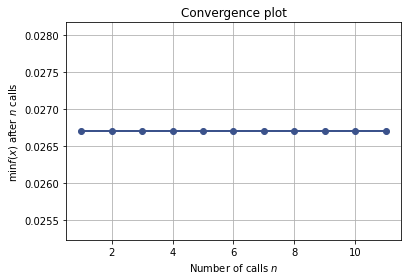

In [27]:
## The convergence for the las model. It could be captured for each model in the loop 
plot_convergence(search_result)
gp_results

### **Model 2: Model Next and Next_Next**

In [28]:
TARGETS = [['CloseNext'], ['CloseNextNext']] 
config_feature['columns'] = ['Date', 'Open', 'High', 'Low', 'Volume', 'AdjustedClose', 'Target', TARGETS[0][0], TARGETS[1][0]]

NUM_MODELS = 33

#if ((TARGET[0][0] == 'CloseNext') or (TARGET[1][0] == 'CloseNextNext')): 
df_train_model_next_raw = df_stock_price_next.set_index('Date').loc[TRAIN_START:TRAIN_END, :]
df_test_model_next_raw = df_stock_price_next.set_index('Date').loc[TEST_START:, :]  

print('Target :', TARGETS, ', NUM_MODELS:', NUM_MODELS, ', len features:',len(FEATURES))

print(df_train_model_next_raw.index)
print(df_test_model_next_raw.index)
## 33 models using the 33SectorCode code sectors
if NUM_MODELS == 33:
    list_codes_models = list_33SectorCode.copy()
        
    df_train_model_next_raw.reset_index(inplace=True)
    df_train_model_next_raw.set_index('33SectorCode', inplace=True)
    display(df_train_model_next_raw.head(3))

    df_test_model_next_raw.reset_index(inplace=True)
    df_test_model_next_raw.set_index('33SectorCode', inplace=True)
    display(df_test_model_next_raw.head(3))


Target : [['CloseNext'], ['CloseNextNext']] , NUM_MODELS: 33 , len features: 25
DatetimeIndex(['2020-12-23', '2020-12-24', '2020-12-25', '2020-12-28',
               '2020-12-29', '2020-12-30', '2021-01-04', '2021-01-05',
               '2021-01-06', '2021-01-07',
               ...
               '2021-11-08', '2021-11-09', '2021-11-10', '2021-11-11',
               '2021-11-12', '2021-11-15', '2021-11-16', '2021-11-17',
               '2021-11-18', '2021-11-19'],
              dtype='datetime64[ns]', name='Date', length=446000, freq=None)
DatetimeIndex(['2021-12-06', '2021-12-07', '2021-12-08', '2021-12-09',
               '2021-12-10', '2021-12-13', '2021-12-14', '2021-12-15',
               '2021-12-16', '2021-12-17',
               ...
               '2022-06-09', '2022-06-10', '2022-06-13', '2022-06-14',
               '2022-06-15', '2022-06-16', '2022-06-17', '2022-06-20',
               '2022-06-21', '2022-06-22'],
              dtype='datetime64[ns]', name='Date', length=26587

,Date,SecuritiesCode,Open,High,Low,Volume,Target,AdjustedClose,17SectorName,CloseNext,CloseNextNext
33SectorCode,,,,,,,,,,,
50,2020-12-23,1301,2913.0,2920.0,2906.0,6300,-0.000343,2913.0,FOODS,2917.0,2916.0
50,2020-12-24,1301,2913.0,2937.0,2909.0,13900,0.011660,2917.0,FOODS,2916.0,2950.0
50,2020-12-25,1301,2903.0,2930.0,2903.0,8300,0.003729,2916.0,FOODS,2950.0,2961.0


,Date,SecuritiesCode,Open,High,Low,Volume,Target,AdjustedClose,17SectorName,CloseNext,CloseNextNext
33SectorCode,,,,,,,,,,,
50,2021-12-06,1301,2982.0,2982.0,2965.0,8900,-0.003263,2971.0,FOODS,3065.0,3055.0
50,2021-12-07,1301,2998.0,3065.0,2990.0,19100,0.009820,3065.0,FOODS,3055.0,3085.0
50,2021-12-08,1301,3080.0,3080.0,3035.0,11600,0.006483,3055.0,FOODS,3085.0,3105.0


In [29]:
print(list_codes_models)
print(len(list_metrics_from_hp_search['CloseNext']), len(list_metrics_from_hp_search['CloseNextNext']))
print(len(list_hp_from_hp_search['CloseNext']), len(list_hp_from_hp_search['CloseNextNext']))
print(len(list_models_from_hp_search['CloseNext']), len(list_models_from_hp_search['CloseNextNext']))

[5250 9050 6100 3650 6050 3200 3600 2050 3050 8050 7050 3700 3800 3250
 5050 3550 3750 3400 7200 3450 4050 3500 3100 7100 5200 3350 7150 3150
 3300   50 5100 1050 5150]
0 0
0 0
0 0


In [30]:
num_folds = 3 #folds for cross validation
n_calls = 11 #iterations for hyperparameters search method

df_train_raw = df_train_model_next_raw.copy()
df_test_raw = df_test_model_next_raw.copy()
    
for TARGET in TARGETS:    
    list_metrics_from_hp_search[TARGET[0]] = []
    list_hp_from_hp_search[TARGET[0]] = []
    list_models_from_hp_search[TARGET[0]] = []
    
    start = time.time()    

    for code_sec in tqdm(list_codes_models[0:2]):

        x_train_raw = df_train_raw.loc[code_sec].copy()
        x_test_raw = df_test_raw.loc[code_sec].copy()    

        print("\ntrain:", x_train_raw.shape, x_train_raw.columns, 
             "\ntest:", x_test_raw.shape, x_test_raw.columns)

        manage_split = Manage_split_features(x_train_raw, config_feature, num_folds, num_iterations=n_calls)

        iteration = 0
        list_metrics_results = []
        default_parameters = [0.1, 9, 6, 0.8, 0.8, 0.1, 50]
        search_result = gp_minimize(func=fitness,
                                    dimensions=dimensions,
                                    acq_func='EI', # Expected Improvement.
                                    n_calls=n_calls,
                                    x0=default_parameters)

        gp_results = pd.DataFrame(np.hstack([search_result.func_vals.reshape(-1,1), np.array(search_result.x_iters)])).sort_values(0)
        gp_results.columns = ['metric', 'learning_rate', 'max_depth', 'min_child_weight', 'subsample', 
                              'colsample_bytree', 'reg_alpha', 'n_estimators']
        gp_results['metric'] = gp_results['metric'].astype(np.float32)
        gp_results = pd.concat([gp_results, pd.DataFrame(list_metrics_results)], axis=1)
        gp_results = gp_results.sort_values('metric')

        best_hp = gp_results.iloc[0, 1:8].to_dict()

        best_hp['max_depth'] = int(best_hp['max_depth'])
        best_hp['n_estimators'] = int(best_hp['n_estimators'])             
        print('top:',0, 'param:', best_hp)    

        print('\ncomputing features train and test')
        x_train = get_features(config_feature, x_train_raw)            
        x_test = get_features(config_feature, x_test_raw)
        print('TARGET', TARGET)
        model, df_rmse_train, df_rmse_test = train_model(best_hp, x_train[FEATURES].values, x_train[TARGET].values, 
                                                         x_test[FEATURES].values, x_test[TARGET].values)

        print('rmse train:', df_rmse_train.mean(),' rmse test:', df_rmse_test.mean(),'\n')

        list_metrics_from_hp_search[TARGET[0]].append({'rmse train':df_rmse_train.mean(), 'rmse test':df_rmse_test.mean()})
        list_hp_from_hp_search[TARGET[0]].append({'code_sec': code_sec, 'hp':best_hp})    
        list_models_from_hp_search[TARGET[0]].append({'code_sec': code_sec, 'model':model})    

    print("Time for each model: ", TARGET, " ", time.time()-start)    

*** ---- Hyperparameters ---- ***
{'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.7445826576432508, 'colsample_bytree': 0.1475808544743062, 'reg_alpha': 0.20704750366492708, 'n_estimators': 50}
metrics:
mean_rmse: 1163.9033 weight_mean_rmse: 1163.9033
top: 0 param: {'learning_rate': 0.05, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8703038735279798, 'colsample_bytree': 0.2375170674840533, 'reg_alpha': 0.23051924336915144, 'n_estimators': 100}

computing features train and test
TARGET ['CloseNextNext']


100%|██████████| 2/2 [03:57<00:00, 118.94s/it]

rmse train: 108.63637155211427  rmse test: 406.5804803995252 

Time for each model:  ['CloseNextNext']   237.87999200820923


,metric,learning_rate,max_depth,min_child_weight,subsample,colsample_bytree,reg_alpha,n_estimators,mean_rmse,weight_mean_rmse,cv_rmse_val
1,1123.516724,0.05,9.0,6.0,0.870304,0.237517,0.230519,100.0,1123.52,1123.5167,"[1063.14, 1606.77, 700.64]"
5,1154.536743,0.05,14.0,6.0,0.120146,0.598168,0.151724,50.0,1154.54,1154.5367,"[1135.28, 1700.59, 627.74]"
10,1163.903320,0.10,9.0,6.0,0.744583,0.147581,0.207048,50.0,1163.90,1163.9033,"[959.29, 1431.8, 1100.62]"
8,1194.760010,0.05,9.0,10.0,0.488450,0.661358,0.524550,70.0,1194.76,1194.7600,"[1094.59, 1717.67, 772.02]"
2,1234.989990,0.05,9.0,6.0,0.192304,0.382823,0.109416,50.0,1234.99,1234.9900,"[1168.48, 1788.28, 748.21]"
0,1242.273315,0.10,9.0,6.0,0.800000,0.800000,0.100000,50.0,1242.27,1242.2733,"[1142.09, 1648.97, 935.76]"
3,1277.086670,0.10,14.0,6.0,0.691362,0.728600,0.463003,30.0,1277.09,1277.0867,"[1228.02, 1669.13, 934.11]"
6,1887.886719,0.05,9.0,5.0,0.146536,0.187106,0.701131,30.0,1887.89,1887.8867,"[1718.95, 2393.6, 1551.11]"
9,2811.296631,0.01,10.0,6.0,0.341909,0.976602,0.287251,70.0,2811.30,2811.2967,"[2612.04, 3230.35, 2591.5]"
4,2974.770020,0.01,10.0,10.0,0.314276,0.127965,0.230519,70.0,2974.77,2974.7700,"[2705.48, 3400.5, 2818.33]"


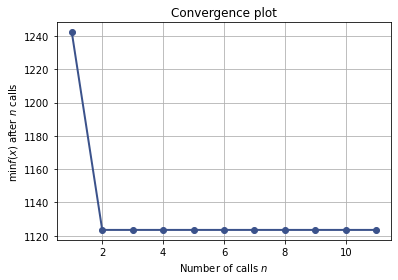

In [31]:
## The convergence for the las model. It could be captured for each model in the loop 
plot_convergence(search_result)
gp_results

In [32]:
print(list_hp_from_hp_search)

{'Target': [{'code_sec': 5250, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}, {'code_sec': 9050, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'n_estimators': 50}}], 'CloseNext': [{'code_sec': 5250, 'hp': {'learning_rate': 0.05, 'max_depth': 14, 'min_child_weight': 1.0, 'subsample': 0.16264963085006756, 'colsample_bytree': 0.7327840739048075, 'reg_alpha': 0.4174144248624989, 'n_estimators': 100}}, {'code_sec': 9050, 'hp': {'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 6.0, 'subsample': 0.3607075274627016, 'colsample_bytree': 0.4922632588554313, 'reg_alpha': 0.5714585114401965, 'n_estimators': 100}}], 'CloseNextNext': [{'code_sec': 5250, 'hp': {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6.0, 'subsample': 0.44597841231618196, 'colsample_bytree': 0.8502071048202803, 'reg_a

In [33]:
display(pd.DataFrame(list_hp_from_hp_search))
display(pd.DataFrame(list_metrics_from_hp_search))

,Target,CloseNext,CloseNextNext
0,"{'code_sec': 5250, 'hp': {'learning_rate': 0.1...","{'code_sec': 5250, 'hp': {'learning_rate': 0.0...","{'code_sec': 5250, 'hp': {'learning_rate': 0.1..."
1,"{'code_sec': 9050, 'hp': {'learning_rate': 0.1...","{'code_sec': 9050, 'hp': {'learning_rate': 0.0...","{'code_sec': 9050, 'hp': {'learning_rate': 0.0..."


,Target,CloseNext,CloseNextNext
0,"{'rmse train': 0.02592323637376784, 'rmse test...","{'rmse train': 154.2086484689268, 'rmse test':...","{'rmse train': 154.53282367308586, 'rmse test'..."
1,"{'rmse train': 0.024322257791877216, 'rmse tes...","{'rmse train': 105.59763021026183, 'rmse test'...","{'rmse train': 108.63637155211427, 'rmse test'..."


## **Visual Examples of the Model Performance**

In [34]:
def plot_examples_performance(df_train_raw, df_test_raw, list_models_from_hp_search, config_feature, model_type='Target', 
                              num_examples=3, date_to_plot=slice('2021-01-01', '2022')):
    
    fig, ax = plt.subplots(2,num_examples, figsize=[30,20])
    
    if model_type=='Target' :
        config_feature['columns'] = ['Date', 'Open', 'High', 'Low', 'Volume', 'AdjustedClose', 'Target']
    if model_type=='CloseNext' or model_type=='CloseNextNext':
        config_feature['columns'] = ['Date', 'Open', 'High', 'Low', 'Volume', 'AdjustedClose', 'CloseNext', 'CloseNextNext']
    
    i = 0         
    for dic_model in list_models_from_hp_search[model_type]:
        code_sector = dic_model['code_sec']
        model_tmp = dic_model['model']    

        x_train = get_features(config_feature, df_train_raw.loc[code_sector])            
        x_test = get_features(config_feature, df_test_raw.loc[code_sector])    

        j = 0
        random_stocks = np.random.choice(x_train.index.unique(), num_examples, replace=False)
        for code_stock in random_stocks:
            x_predict_train_tmp = x_train.loc[code_stock][['Date', model_type]].copy()
            x_predict_train_tmp['Predict_Train'] = model_tmp.predict(x_train.loc[code_stock][FEATURES].values) 

            x_predict_test_tmp = x_test.loc[code_stock][['Date', model_type]].copy()
            x_predict_test_tmp['Predict_Test'] = model_tmp.predict(x_test.loc[code_stock][FEATURES].values) 

            x_predict_train_tmp.set_index('Date').loc[date_to_plot].plot(style='.', ax=ax[i][j])
            x_predict_test_tmp.set_index('Date').loc[date_to_plot].plot(style='.', ax=ax[i][j])

            j += 1

        i += 1
        

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


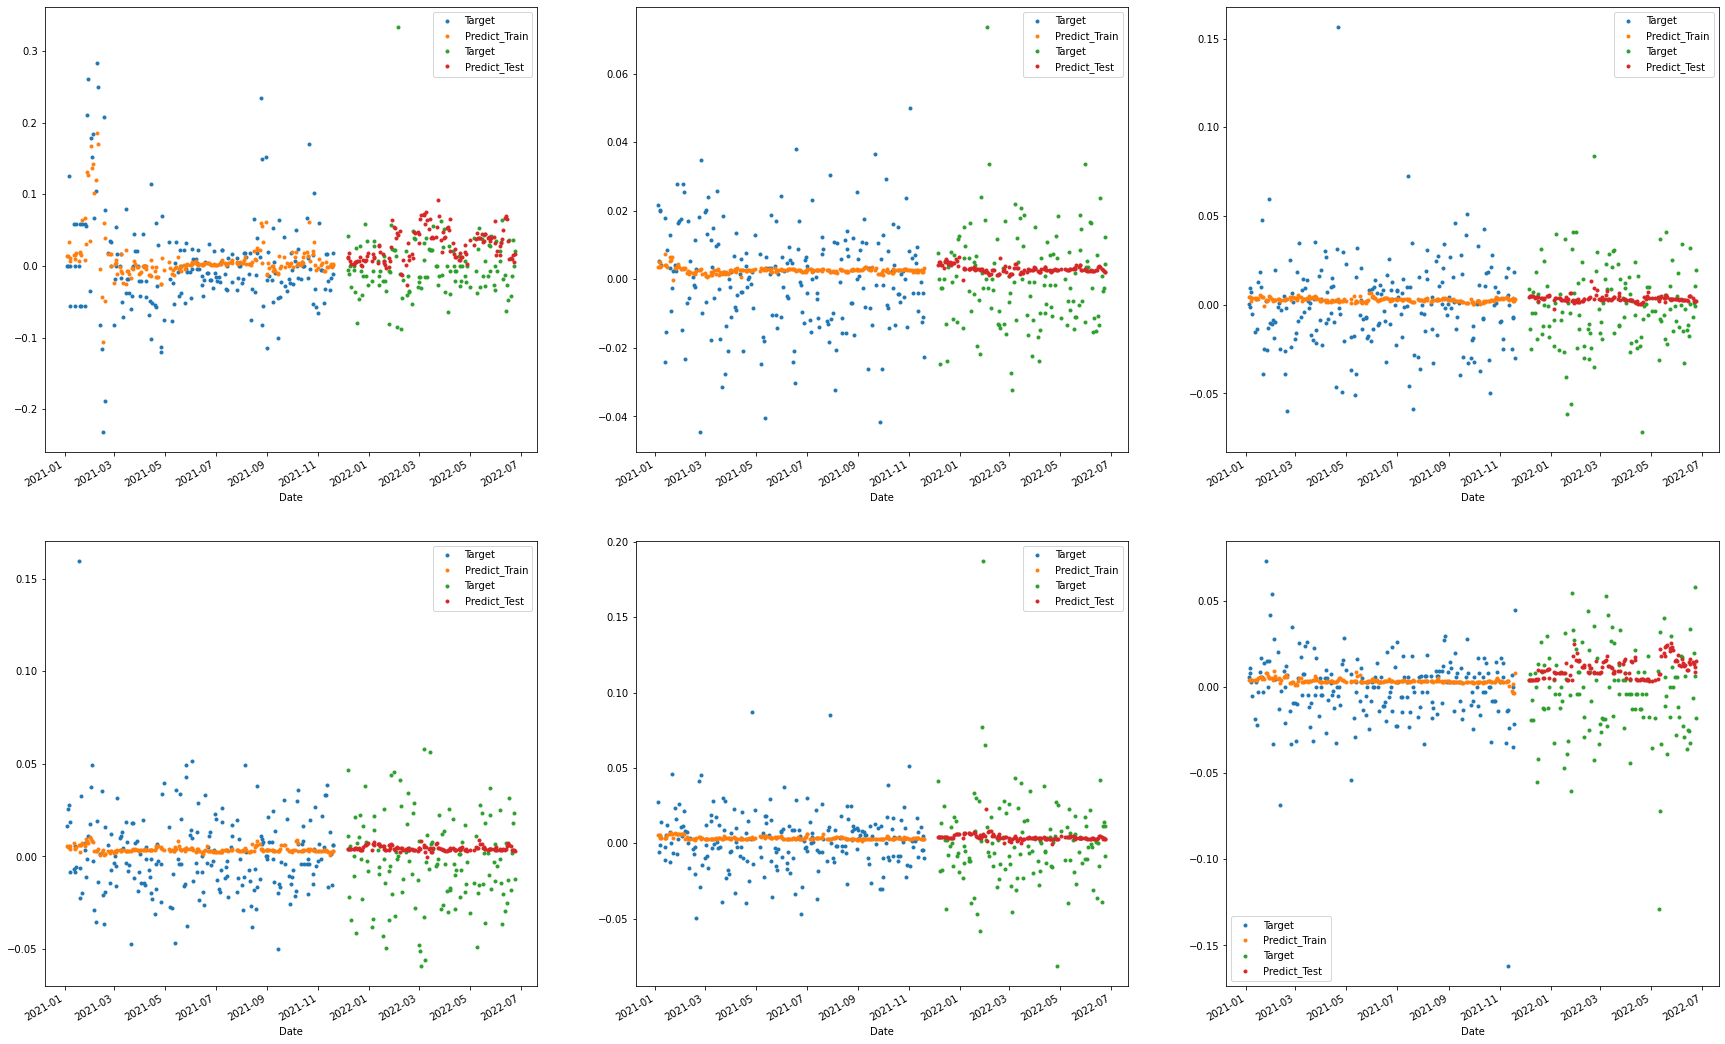

In [35]:
plot_examples_performance(df_train_model_target_raw, df_test_model_target_raw, list_models_from_hp_search, config_feature, 
                          model_type='Target',  num_examples=3, date_to_plot=slice('2021-01-01', '2022'))

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


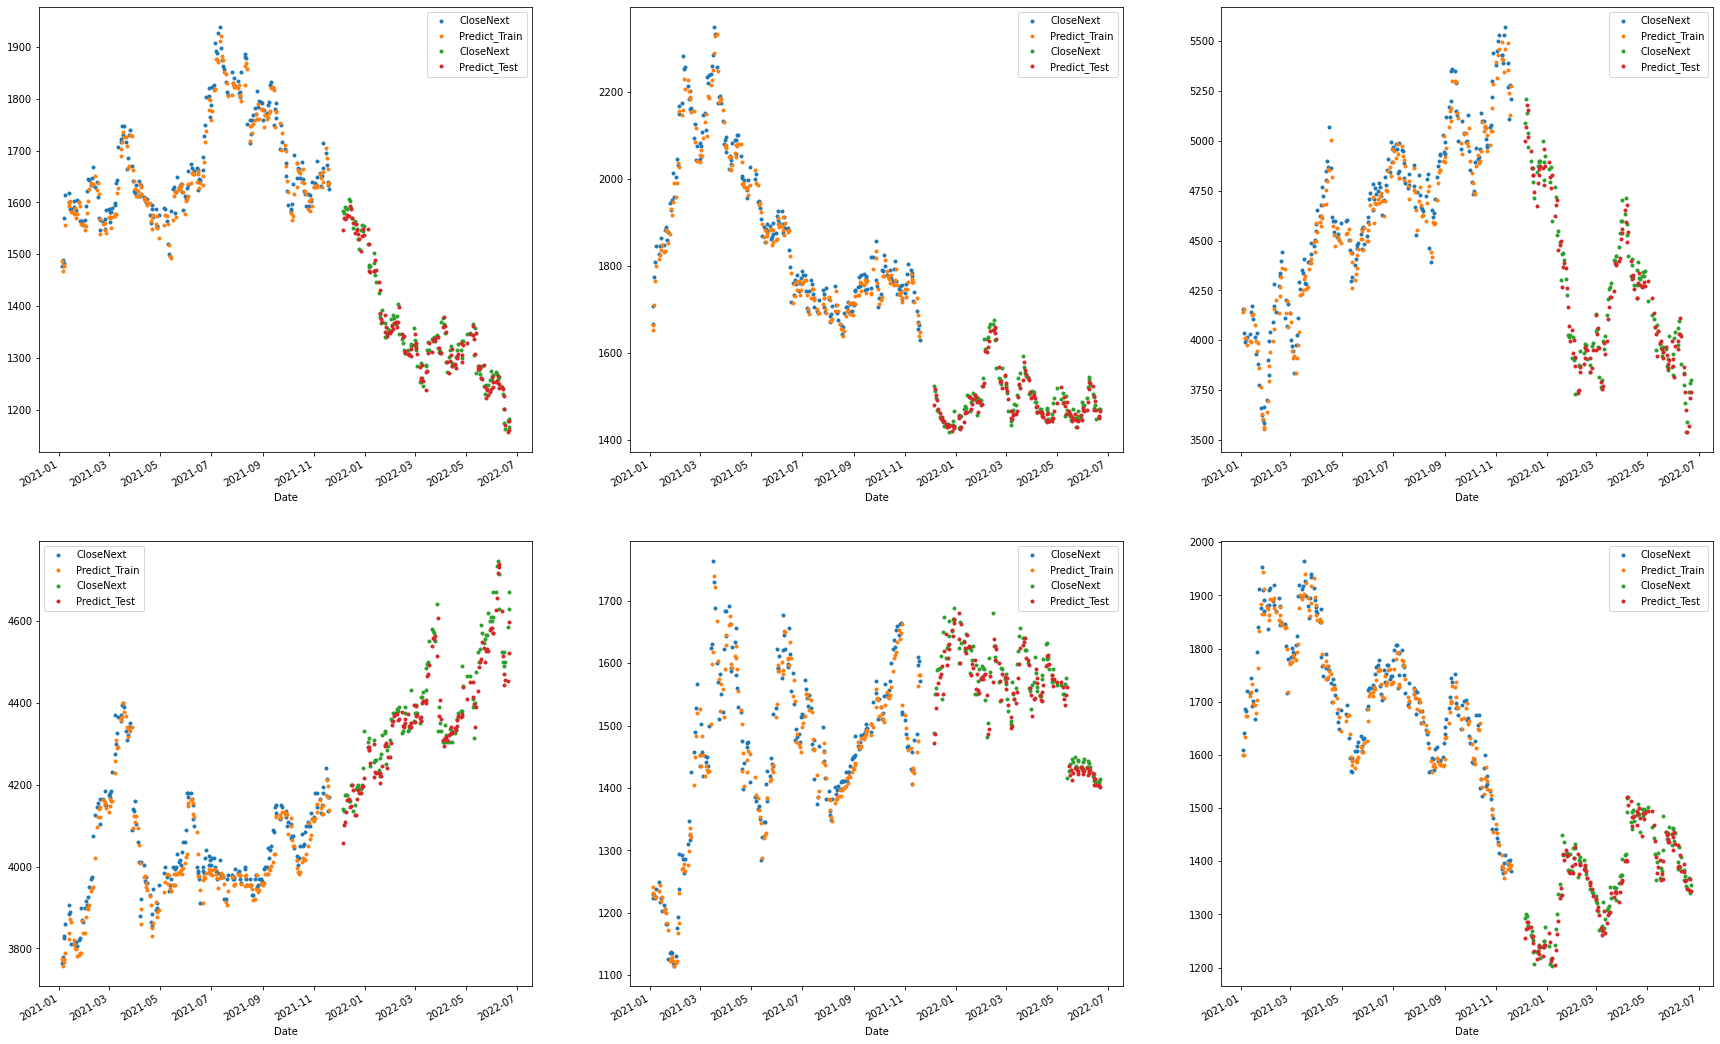

In [36]:
plot_examples_performance(df_train_model_next_raw, df_test_model_next_raw, list_models_from_hp_search, config_feature, 
                          model_type='CloseNext',  num_examples=3, date_to_plot=slice('2021-01-01', '2022'))

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


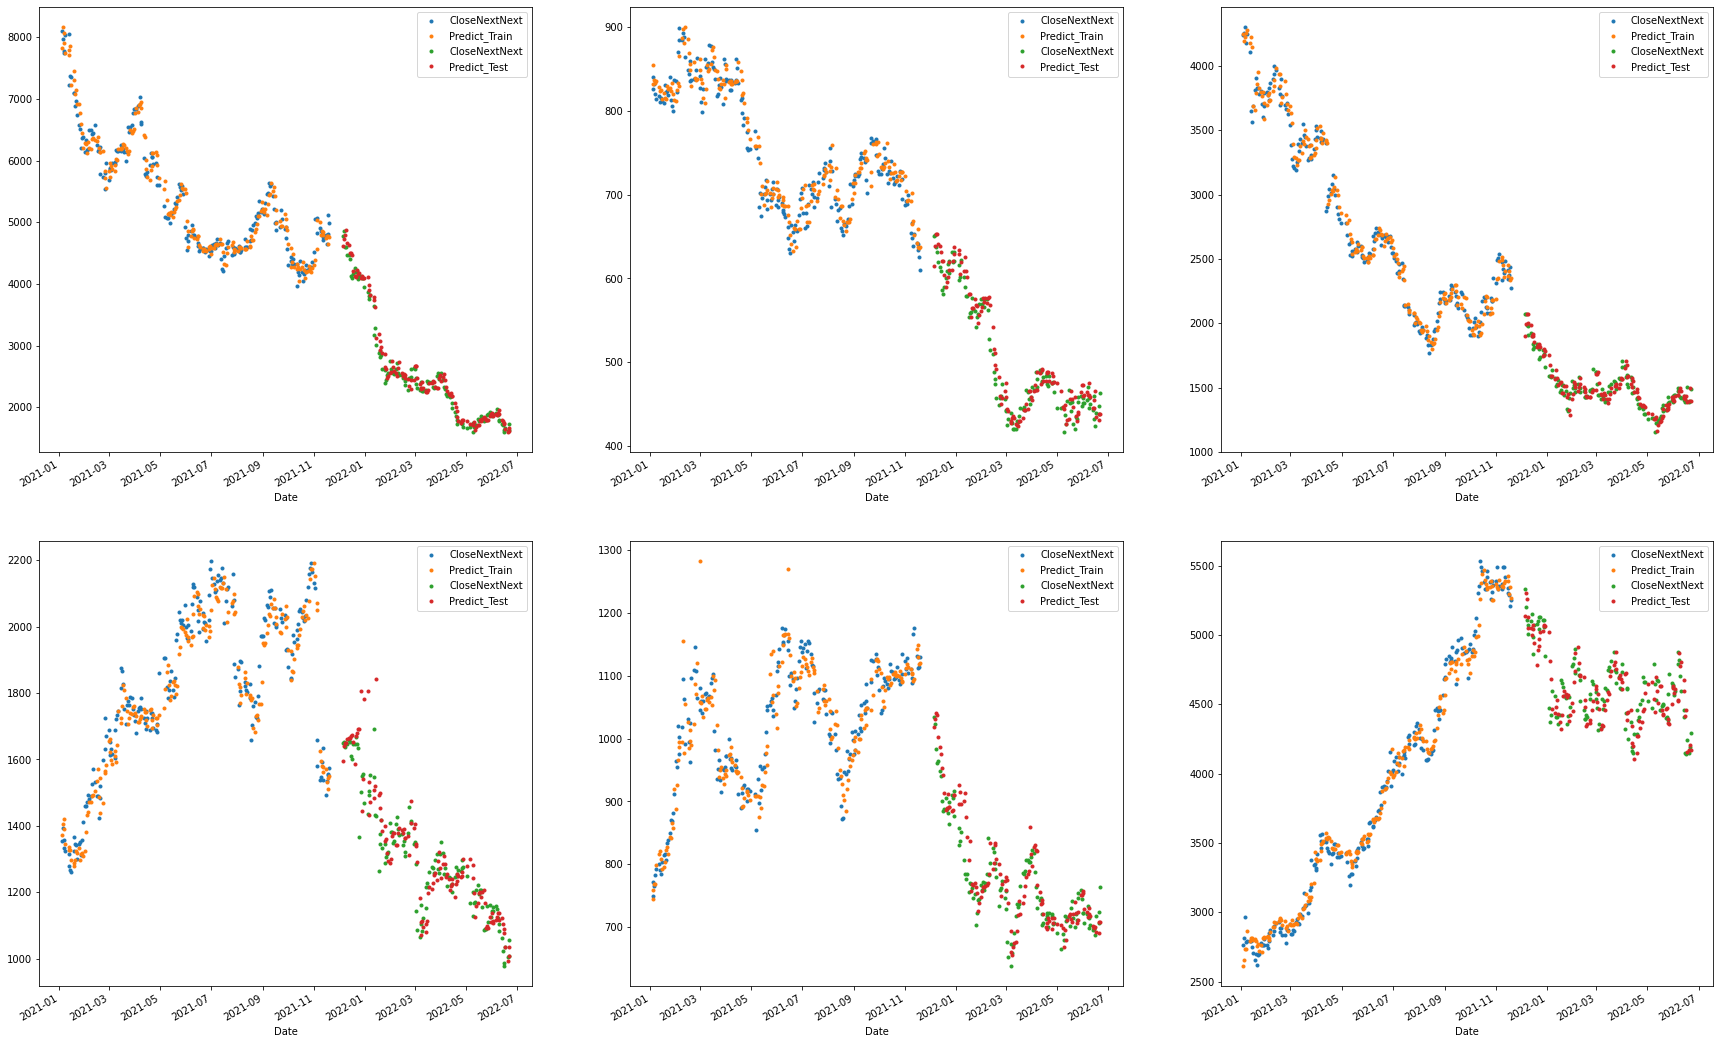

In [37]:
plot_examples_performance(df_train_model_next_raw, df_test_model_next_raw, list_models_from_hp_search, config_feature, 
                          model_type='CloseNextNext',  num_examples=3, date_to_plot=slice('2021-01-01', '2022'))